# Regression Demo

## Tutorial

The aims of this simple demo are to show :

- How to pre-process data for training
- How to set up a training loop
- How to draw samples from the learned model (and make predictions)

## Import packages

In [1]:
repo_root = normpath(@__DIR__, "..") # just repo path

"/Users/andreibleahu/Documents/BayesianMLP/"

In [2]:
include(joinpath(repo_root, "VariationalMLP", "src", "VariationalMLP.jl"))

Main.VariationalMLP

In [3]:
using .VariationalMLP

In [4]:
using Flux, Statistics
using Flux: onehotbatch, onecold, Adam
using Flux.Losses: logitcrossentropy, mse
#using Optimisers
using Zygote
using MLDatasets
using Plots



using MLJBase
using Random
#using Plots
using MLUtils: splitobs

# sampling
using StatsBase
using CSV, DataFrames
using CategoricalArrays

using Distributions
using LinearAlgebra

## Data

In [5]:
# Blundel et al. (2015)
function hidden_signal(x)

    # sample noise

    ϵ = rand(Normal(0, 0.02))
    return x + 0.3 * sin(2*π* (x + ϵ)) +  0.3 * sin(4*π* (x + ϵ)) +  ϵ
end

hidden_signal (generic function with 1 method)

In [6]:
function generate_train_test(size, ntrain)
    """
    Generates synthethic data and
    splits it into training and test data.

    Args

    size : size of data
    ntrain : number of training samples
    """

    Random.seed!(2345)
    xs = shuffle(range(0.0, 1.4, size))
    ys = hidden_signal.(xs) # noise is inbuilt

    xtrain = xs[1:ntrain]
    ytrain = ys[1: ntrain]

    xtest = xs[(ntrain+1): end]
    ytest = ys[(ntrain+1): end]

    return xtrain, ytrain, xtest, ytest

end 

generate_train_test (generic function with 1 method)

In [7]:
xtrain, ytrain, xtest, ytest = generate_train_test(500, 40)

([1.1559118236472945, 0.6929859719438878, 1.3887775551102204, 1.3018036072144288, 0.7042084168336673, 1.2176352705410822, 1.3186372745490982, 0.558316633266533, 0.09539078156312625, 0.0813627254509018  …  0.7182364729458918, 0.8136272545090181, 0.3927855711422846, 0.12344689378757515, 0.561122244488978, 0.8725450901803607, 1.3298597194388777, 0.3030060120240481, 0.46012024048096195, 0.2973947895791583], [1.6852064172342507, 0.6352436456237094, 1.293449245412251, 1.3763259301648025, 0.5725454662015237, 1.6595597375098408, 1.3184399221123402, 0.7064359352382394, 0.4528811605580514, 0.6359089757920382  …  0.5429214611262958, 0.3141916282884264, 0.2867487468586288, 0.6520205931554687, 0.7046618464842556, 0.32570302324743716, 1.349919034013978, 0.5009801575011184, 0.3403271652813983, 0.37100856515113917], [1.3158316633266534, 0.7771543086172344, 0.5246492985971943, 0.0028056112224448897, 0.6733466933867736, 0.28617234468937874, 0.917434869739479, 0.14308617234468937, 0.6705410821643286, 0.9

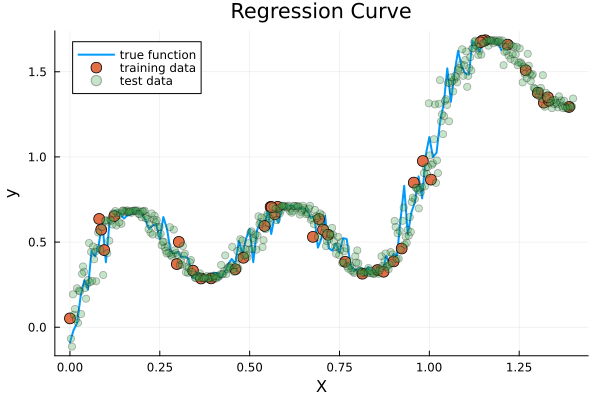

In [8]:
begin
	fig = plot(0:0.01:1.2, hidden_signal, lw=2, label="true function", title = "Regression Curve", xlabel = "X", ylabel = "y")
	plot!(xtrain, ytrain, st=:scatter, ms=6, label="training data")

	plot!(xtest, ytest, st=:scatter, ms=4, label="test data", alpha=0.3)
end

display(fig)


Julia is row-centric, so we must reshape the feature. 

In [9]:
X_train = reshape(Float32.(xtrain), 1, :)
y_train = Float32.(ytrain)
X_test = reshape(Float32.(xtest), 1, :)
y_test = Float32.(ytest)

460-element Vector{Float32}:
  1.4798548
  0.38753057
  0.6512756
 -0.06753287
  0.64029187
  0.43021122
  0.56535107
  0.60712206
  0.6309517
  0.792684
  ⋮
  0.33320954
  1.5547434
  0.3293572
  1.6862923
  0.69577247
  0.58741623
  0.6393451
  0.76111156
  1.3084958

In [10]:
# Data loader, allows us to process training data in batches
batchsize = 1
data_loader = Flux.DataLoader((X_train, y_train), batchsize=batchsize, shuffle=true)

## Total training dataset length 
N = size(X_train, 2)
println("Training dataset length $N")

Training dataset length 40


## Define model

In [11]:
vd_model  = make_model([1, 64, 1];  
                    activations =[sin],
                   final_activation=identity,
                   variant=:molchanov,  ## change to :graves or :kigma, for different methods
                   init=:random)

VarChain{Vector{Main.VariationalMLP.AbstractVariationalLayer}}(Main.VariationalMLP.AbstractVariationalLayer[VariationalDropoutMolchanov{typeof(sin)}(Float32[-2.435275; -0.8265205; … ; -0.9485288; -0.6170924;;], Float32[1.6514286; -0.9949574; … ; -0.26640645; 0.3892726;;], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], sin), VariationalDropoutMolchanov{typeof(identity)}(Float32[-1.1619178 0.49534112 … -1.0658168 0.63901514], Float32[0.7419601 -2.9948387 … 0.025934521 1.4792485], Float32[0.0], identity)])

In [12]:
vd_model = make_model([1, 64, 1]; activations=[sin], final_activation=identity, variant=:molchanov, init=:random)

ps = Flux.params(vd_model)

println("Number of trainable params: ", length(ps))

for p in ps
    println(size(p))
end


Number of trainable params: 6
(64, 1)
(64, 1)
(64,)
(1, 64)
(1, 64)
(1,)


We have  have two layers, (1, 64) and (64, 1), each with three parameters:

- Layer 1 : $\theta_1$, $\ln \sigma^2_1$, $b_1$ 
- Layer 2 : $\theta_2$, $\ln \sigma^2_2$, $b_2$ 

In total 6 parameters, all trainable. Next, I will show that these parameters change as a result of training the model. 

In [13]:
# Make deep copies of layers
first_layer = vd_model.layers[1]
second_layer = vd_model.layers[2]

# deep copy ensures that these are not automatically updated during training 
## first layer
θ1_init = deepcopy(first_layer.θ)
logσ21_init = deepcopy(first_layer.logσ2)
bias1_init = deepcopy(first_layer.bias)

## second layer
θ2_init = deepcopy(second_layer.θ)
logσ22_init = deepcopy(second_layer.logσ2)
bias2_init = deepcopy(second_layer.bias)


1-element Vector{Float32}:
 0.0

We can check the sizes are as expected. 

In [14]:
println(size(θ1_init), size(logσ21_init), size(bias1_init))

(64, 1)(64, 1)(64,)


In [15]:
println(size(θ2_init), size(logσ22_init), size(bias2_init))

(1, 64)(1, 64)(1,)


In [16]:
# ==============/* Initialization */ ==============
η = 0.1 # learning rate
total_epochs = 500 
warmup_epochs = 150 # KL divergence is turned of 
max_kl_scale = 1.0f0 # shows
enable_warmup = :true
task_type = :regression
verbose = :true # prints intermediary results 



# Step 1 :Initialize optimizer and model (vd_model) 
opt = Flux.setup(Adam(η), vd_model)

# Step 2 : Initialize empty logs
losses = Float32[]
sparsity_log = []

# ==============/* Training over batches */ ==============

# Step 5 : run through epochs 
for epoch in 1:total_epochs
    epoch_loss = 0.0f0

    if enable_warmup
        # Step 6 : Annealing schedule (in algorithm 3, Step 4 defines it as function; here they are combined)
        kl_scale = epoch <= warmup_epochs ? 0.0f0 : max_kl_scale * Float32((epoch - warmup_epochs) / (total_epochs - warmup_epochs))
    else

        #no warm up; KL divergence is introduced all at once
        kl_scale = 1.0f0
    end


    # Step 7
    for (x, y) in data_loader

        # Steps 8 -9 
        loss, grads = Flux.withgradient(vd_model) do m 
            energy_loss(m, x, y, N; kl_scale=kl_scale,
                                    enable_warmup=enable_warmup,
                                    task_type=task_type)
        end

        # Steps 10
        Flux.update!(opt, vd_model, grads[1])
        epoch_loss += loss # sum over batches per epoch
        end

        # ==============/* Logging and return */ ==============


        # Save metrics
        push!(losses, epoch_loss)
        sparsities = model_sparsity(vd_model)
        push!(sparsity_log, sparsities)

        if verbose
            println("Epoch $epoch | Loss = $(round(epoch_loss, digits=4)) | Sparsities: ", round.(sparsities, digits=3))
        end
    end

Epoch 1 | Loss = 135062.52 | Sparsities: [0.141, 0.172]
Epoch 2 | Loss = 64814.7 | Sparsities: [0.125, 0.156]
Epoch 3 | Loss = 44711.53 | Sparsities: [0.125, 0.172]
Epoch 4 | Loss = 37075.293 | Sparsities: [0.078, 0.109]
Epoch 5 | Loss = 17731.967 | Sparsities: [0.062, 0.188]
Epoch 6 | Loss = 18027.914 | Sparsities: [0.125, 0.203]
Epoch 7 | Loss = 16718.896 | Sparsities: [0.156, 0.234]
Epoch 8 | Loss = 11830.913 | Sparsities: [0.156, 0.234]
Epoch 9 | Loss = 10642.811 | Sparsities: [0.156, 0.172]
Epoch 10 | Loss = 13024.354 | Sparsities: [0.172, 0.125]
Epoch 11 | Loss = 16417.783 | Sparsities: [0.156, 0.156]
Epoch 12 | Loss = 8600.552 | Sparsities: [0.141, 0.078]
Epoch 13 | Loss = 7785.216 | Sparsities: [0.156, 0.219]
Epoch 14 | Loss = 8413.833 | Sparsities: [0.109, 0.219]
Epoch 15 | Loss = 5544.3267 | Sparsities: [0.172, 0.188]
Epoch 16 | Loss = 7064.22 | Sparsities: [0.109, 0.234]
Epoch 17 | Loss = 6517.882 | Sparsities: [0.109, 0.219]
Epoch 18 | Loss = 6217.37 | Sparsities: [0.109, 0

In [17]:
vd_model

VarChain{Vector{Main.VariationalMLP.AbstractVariationalLayer}}(Main.VariationalMLP.AbstractVariationalLayer[VariationalDropoutMolchanov{typeof(sin)}(Float32[-4.1653337; 2.623827; … ; -16.614359; 4.058859;;], Float32[7.8115544; 0.9279805; … ; 6.4694276; 0.58017135;;], Float32[2.809979, 1.68406, -5.555267, 4.4979506, 2.724897, -1.7964556, 7.5112505, 14.398309, 6.7171946, -10.662163  …  4.3255177, -6.557102, -2.301529, -2.6383805, 12.324915, -2.6451793, -14.538775, 9.544472, -17.94084, -2.7596798], sin), VariationalDropoutMolchanov{typeof(identity)}(Float32[-0.4818043 -0.24246116 … -0.35831156 0.28805637], Float32[-10.033364 -8.581682 … -8.518067 -11.55477], Float32[0.8242463], identity)])

Let's now save the trained layers and compare. 

In [18]:
# Make deep copies of layers
first_layer = vd_model.layers[1]
second_layer = vd_model.layers[2]

# deep copy ensures that these are not automatically updated during training 
## first layer
θ1_train = deepcopy(first_layer.θ)
logσ21_train= deepcopy(first_layer.logσ2)
bias1_train = deepcopy(first_layer.bias)

## second layer
θ2_train = deepcopy(second_layer.θ)
logσ22_train = deepcopy(second_layer.logσ2)
bias2_train = deepcopy(second_layer.bias)


1-element Vector{Float32}:
 0.8242463

We can simply check for equality, and see if these are different. If equality tests `false`, then it is clear that these parameters changed as results of training. 

In [19]:
# First layer
println(θ1_train == θ1_init)
println(logσ21_train == logσ21_init)
println(bias1_train == bias1_init)

# second layer
println(θ2_train == θ2_init)
println(logσ22_train == logσ22_init)
println(bias2_train == bias2_init)


false
false
false
false
false
false


Clearly, all parameters were trained, so they changed. This confirms that the model is learning a Gaussian, not some fixed parameters. 

## Simple predictions demo

In [20]:
vd_model

VarChain{Vector{Main.VariationalMLP.AbstractVariationalLayer}}(Main.VariationalMLP.AbstractVariationalLayer[VariationalDropoutMolchanov{typeof(sin)}(Float32[-4.1653337; 2.623827; … ; -16.614359; 4.058859;;], Float32[7.8115544; 0.9279805; … ; 6.4694276; 0.58017135;;], Float32[2.809979, 1.68406, -5.555267, 4.4979506, 2.724897, -1.7964556, 7.5112505, 14.398309, 6.7171946, -10.662163  …  4.3255177, -6.557102, -2.301529, -2.6383805, 12.324915, -2.6451793, -14.538775, 9.544472, -17.94084, -2.7596798], sin), VariationalDropoutMolchanov{typeof(identity)}(Float32[-0.4818043 -0.24246116 … -0.35831156 0.28805637], Float32[-10.033364 -8.581682 … -8.518067 -11.55477], Float32[0.8242463], identity)])

Since each prediction is stochastic, I will draw 200 samples, and compute the mean and standard deviation. This is because each prediction depends on the noise drawn $\epsilon$, which takes the mean and variance of the Gaussian and samples them as weights.

In [21]:
n_samples = 1000
predictions = [vd_model(X_test) for _ in 1:n_samples]
println("Number of predictions: ", size(predictions)) 

Number of predictions: (1000,)


In [22]:
predictions

1000-element Vector{Matrix{Float32}}:
 [1.6720484 1.8804387 … 2.7642062 0.06514174]
 [3.2648506 0.95140636 … 0.9898763 2.1267161]
 [1.9709682 1.4534469 … 1.6766505 2.6564922]
 [0.59915614 2.5126915 … 3.0028725 2.3858573]
 [1.5304809 1.8059623 … 2.0558963 0.23412365]
 [1.3275801 0.88452935 … 1.5443898 0.57352716]
 [0.3107571 2.0749154 … -1.3020784 -1.5263418]
 [1.2892492 1.240201 … -0.24522126 -0.0669387]
 [2.415842 2.2164354 … 1.3227015 2.9795246]
 [2.1243248 1.8376057 … 0.70713663 1.0888686]
 ⋮
 [0.99360013 1.5235577 … 0.27642643 0.7380822]
 [1.3207196 2.8163106 … 0.14324397 1.9198077]
 [2.984529 1.0826896 … 1.5952604 1.27476]
 [3.4117398 2.8373733 … 1.5837759 0.6000663]
 [1.2332389 1.0942767 … 0.2993347 -0.6113777]
 [-0.56635845 1.4564415 … 2.0333567 1.1295903]
 [0.8142532 0.5519856 … -0.29349375 0.889752]
 [1.312832 1.3886857 … 2.0001314 0.98968554]
 [2.1001196 1.740855 … -0.38872838 -0.55854666]

In [23]:
pred_mat = reduce(vcat, predictions)  # shape: n_samples × N

1000×460 Matrix{Float32}:
  1.67205   1.88044    0.0244882   …   0.94877      2.76421    0.0651417
  3.26485   0.951406  -0.489106        0.107961     0.989876   2.12672
  1.97097   1.45345   -0.00230837     -0.00718629   1.67665    2.65649
  0.599156  2.51269    0.31553         0.16272      3.00287    2.38586
  1.53048   1.80596   -3.3696         -1.76465      2.0559     0.234124
  1.32758   0.884529  -1.4126      …  -0.708284     1.54439    0.573527
  0.310757  2.07492   -2.40171        -1.06898     -1.30208   -1.52634
  1.28925   1.2402    -1.54531        -2.12666     -0.245221  -0.0669387
  2.41584   2.21644    1.01398         1.46567      1.3227     2.97952
  2.12432   1.83761   -0.392815       -0.918876     0.707137   1.08887
  ⋮                                ⋱                          
  0.9936    1.52356   -0.650366       -0.650971     0.276426   0.738082
  1.32072   2.81631   -1.15402        -1.13935      0.143244   1.91981
  2.98453   1.08269    0.801437        0.927047     

In [24]:
mean_preds = mean(pred_mat, dims=1)  # shape: 1 × N
σ_preds = std(pred_mat, dims = 1)

1×460 Matrix{Float32}:
 1.1819  1.11432  1.06427  0.576257  …  0.941148  1.0418  1.1461  1.14848

In [25]:
y_preds_bnn_mean = vec(mean_preds) # transfrom to vector
y_uncert_bnn_mean = vec(σ_preds)

460-element Vector{Float32}:
 1.181904
 1.1143162
 1.0642741
 0.5762568
 1.0865729
 0.94659275
 1.1457584
 0.9031324
 1.0771929
 1.1286268
 ⋮
 1.1219769
 1.1565515
 1.1428117
 1.1365514
 1.0490743
 0.9411479
 1.0418023
 1.1461029
 1.1484833

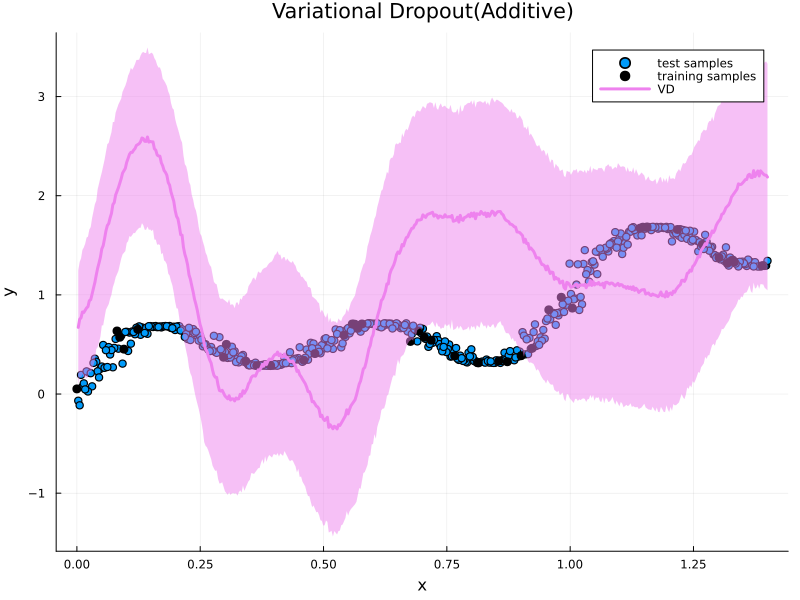

In [26]:
p1 = plot(xtest, ytest, size=(800, 600), seriestype = :scatter, label = "test samples", xlabel = "x", ylabel = "y", title = "Variational Dropout(Additive)")
plot!(xtrain, ytrain, seriestype = :scatter, label = "training samples", color = :black, ms= 5, xlabel = "x", ylabel = "y")
plot!(p1, xtest, y_preds_bnn_mean, ribbon = y_uncert_bnn_mean, seriestype = :line, label = "VD", color = :violet, lw = 3)
display(p1)


Notes:

- The model still requires some experimentation with learning rate and schedule for good results
- This basic demo only shows that Bayesian training updates the variational parameters, and it shows how to draw samples from a learned distribution